# Model Selection

In this notebook we perform model selection with the goal of generating the best classifier for the response variable `IN_LEAGUE_NEXT`, whether or not a given player will play at any point in the next NBA season (and thus have stats data).

We will do all model selection using _only_ the set of training data.

Here is a list of models we will look at:

1. Logistic Regression

2. Logistic Regression with the Synthetic Minority Oversampling Technique (SMOTE)

3. Linear Discriminant Analysis (LDA)

4. Gaussian Naive Bayes

5. Principal Component Analysis (PCA) + K-Nearest Neighbors (KNN)

6. Principal Component Analysis (PCA) + Quadratic Discriminant Analysis (QDA)

7. Decision Tree Classifier

8. Random Forest Classifier

9. AdaBoost Classifier

10. XGBoost Classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from HelperFunctions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Loading the data

In [2]:
# load the data and drop TEAMS_LIST and POS rows
df = pd.read_csv("./train_data.csv").drop(columns=['TEAMS_LIST', 'POS'])

## Imputing and scaling

Note that all of the transformations we will perform here will be performed "within season," meaning that the data for a given season is transformed using information from *only* that season and no other. In particular, since at the time of prediction we will have access to all of the data for that particular season, there is no data leakage occurring.

We impute all stats data with zeros, and fill missing salaries with the season's mean salary.  We define a custom `StandardScaler` which scales data within each season as well.

In [3]:
# check how many missing values in each column
len(df) - df.count()[df.count() < len(df)]

PER              3
TS_PERCENT      35
X3P_AR          40
F_TR            40
ORB_PERCENT      3
DRB_PERCENT      3
TRB_PERCENT      3
AST_PERCENT      3
STL_PERCENT      3
BLK_PERCENT      3
TOV_PERCENT     27
USG_PERCENT      3
WS_48            3
SALARY         568
dtype: int64

In [4]:
df = ImputeAndScale(df)

In [5]:
# check that it worked: randomly select a rescaled column, and check that the mean for each season
# is 0 and the standard deviation is 1
cols_to_rescale = df.select_dtypes(include=['float']).columns

# display numbers smaller than 1e-15 as 0
pd.set_option('display.chop_threshold', 1e-15)

random_rescaled_col = np.random.choice(cols_to_rescale)

print(f"Randomly selected rescaled column: {random_rescaled_col}")
df.groupby("SEASON_START")[random_rescaled_col].describe()[["mean", "std"]]

Randomly selected rescaled column: X3P_AR


,mean,std
SEASON_START,,
1990,0.000000e+00,1.001294
1991,0.000000e+00,1.001298
1992,0.000000e+00,1.001285
1993,0.000000e+00,1.001243
1994,0.000000e+00,1.001231
1995,0.000000e+00,1.001168
1996,0.000000e+00,1.001136
1997,0.000000e+00,1.001141
1998,0.000000e+00,1.001138


## Correlations

Now we'll look at correlations between the predictors and the response variable.  Below we grab the numeric columns and make a correlation heatmap before printing the correlations with `IN_LEAGUE_NEXT`.

In [6]:
df.columns

Index(['NAME', 'PLAYER_ID', 'SEASON_START', 'PLAYER_AGE', 'EXPERIENCE', 'GP',
       'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT',
       'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT',
       'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS', 'DWS', 'WS',
       'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'SALARY', 'WAIVED', 'RELEASED',
       'TRADED', 'WAIVED_OFF', 'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF',
       'RELEASED_REG', 'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG',
       'TRADED_POST', 'IN_LEAGUE_NEXT'],
      dtype='object')

In [7]:
# grab all columns
all_cols = list(df.columns)

# grab just the columns with numeric data
num_cols = df.select_dtypes(include='number').columns.drop('PLAYER_ID')

# grab just the predictors for later; NOTE: leaving out SEASON_START as a predictor
predictors = num_cols.drop(['SEASON_START', 'IN_LEAGUE_NEXT'])

In [8]:
predictors

Index(['PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT',
       'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT',
       'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT',
       'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'SALARY', 'WAIVED', 'RELEASED', 'TRADED', 'WAIVED_OFF',
       'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF', 'RELEASED_REG',
       'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG', 'TRADED_POST'],
      dtype='object')

IN_LEAGUE_NEXT    1.000000
GP                0.505385
PF                0.460802
MIN               0.454275
FGA               0.396110
FGM               0.395826
PTS               0.391002
TOV               0.390322
WAIVED            0.378325
DREB              0.377827
STL               0.374977
REB               0.373683
DWS               0.364216
WAIVED_REG        0.355055
WS                0.351836
Name: IN_LEAGUE_NEXT, dtype: float64


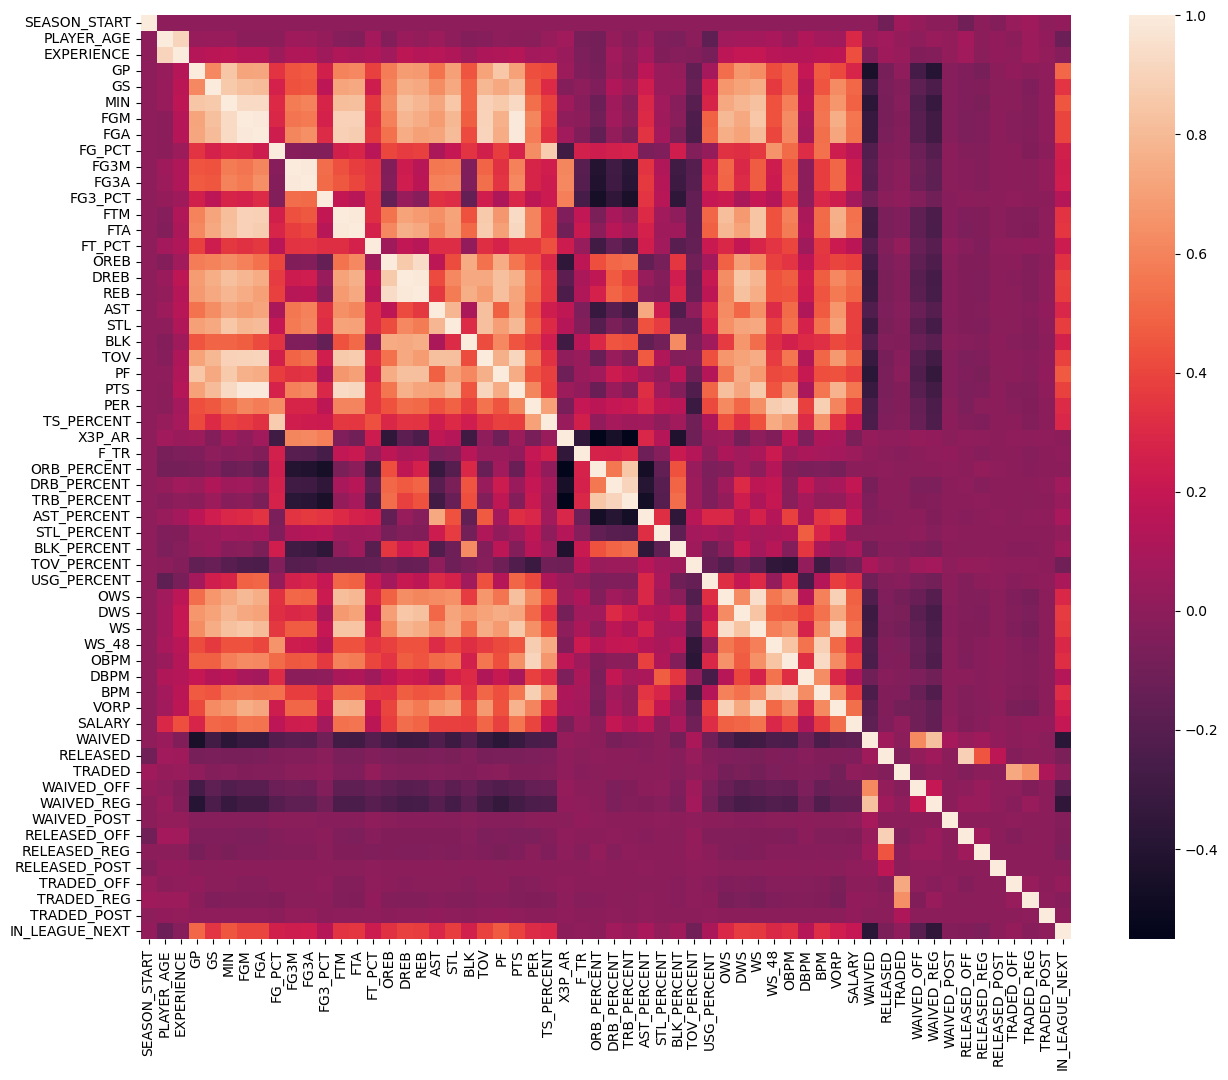

In [9]:
# compute correlations between numeric data columns
corr = df[num_cols].corr()

# print top 15 or so |correlations| with IN_LEAGUE_NEXT in descending order
print(abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)[0:15])

# plot heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

## Split data into a training set and a calibration set

After choosing a model, we calibrate the model's predicted probabilities.  In order to do these two operations we need distinct sets of data; the model will be chosen and fit using `df_train`, and the model will be calibrated using `df_cal`.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_train, df_cal = train_test_split(df, test_size=0.2, random_state=815, 
                                    shuffle=True, stratify=df.IN_LEAGUE_NEXT)

df_train.reset_index(inplace=True)
df_cal.reset_index(inplace=True)

## Cross validation

We will use cross validation to evaluate the performance of our models. Moreover, we will use `GridSearchCV` to perform hyperparameter tuning.

In [12]:
from sklearn.model_selection import GridSearchCV

### Walk-forward validation

Since we aim to use known current-season player/stats data to predict whether a player is in the NBA in the future (next season), we have to worry about not introducing "future" data in the training/validation process.  For this reason we will use a time series approach to cross-validation known as "walk-forward validation" (with an expanding window).

Specifically, we will do a time series cross-validation with 5 splits to estimate the performance of each model we consider.  The splits will have the following structure:

| CV split | CV train set seasons | CV validation set seasons |
| ---      | ---                  | ---                       |
| 1        | 1990 - 2011          | 2012                      |
| 2        | 1990 - 2012          | 2013                      |
| 3        | 1990 - 2013          | 2014                      |
| 4        | 1990 - 2014          | 2015                      |
| 5        | 1990 - 2015          | 2016                      |

where the minimum size of a CV training set is that of the first split, which uses 79% of `df_train`; this is computed (along with the number of rows in the training/validation sets for each split) in the cell below.

In [13]:
# create list containing (train, val) split indices
cv = []

for year in range(2012, 2017):
    train_idxs = df_train[df_train['SEASON_START'] < year].index
    val_idxs = df_train[df_train['SEASON_START'] == year].index
    cv.append((train_idxs, val_idxs))

In [14]:
print(f"First split trains on {len(cv[0][0])/len(df_train)*100:.0f}% of df_train.\n")

for split in range(5):
    print(f"Split {split} has train size {len(cv[split][0])} and val. size {len(cv[split][1])}")

First split trains on 80% of df_train.

Split 0 has train size 7667 and val. size 370
Split 1 has train size 8037 and val. size 384
Split 2 has train size 8421 and val. size 385
Split 3 has train size 8806 and val. size 376
Split 4 has train size 9182 and val. size 390


### Performance metrics

Below we define a helper functions `avg_cv_metrics` and `print_cv_metrics` which compute and display, respectively, all of the measures of classifier performance we will use during the model selection process.

Since our classes are imbalanced (far more players stay in the NBA each year than leave), in most of our modeling approaches we will use the Synthetic Minority Oversampling Technique (SMOTE) from the `imblearn` library. We note that `imblearn` has a `Pipeline` object which extends that of `sklearn` and allows us to use this resampling technique inside of our pipelines.

In [15]:
# show that we have imbalanced classes
df_train.IN_LEAGUE_NEXT.value_counts(normalize=False)

IN_LEAGUE_NEXT
1    7748
0    1824
Name: count, dtype: int64

## Comparing models

### Model 1: Logistic Regression

Let's begin by finding the CV performance of a simple logistic regression model on the training set.  We train this model without accounting for the fact that our classes (values of `IN_LEAGUE_NEXT`) are imbalanced.

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
log_reg = LogisticRegression(max_iter=10000)

param_grid = {'C': np.logspace(-4, 2, 7)}

grid_search = GridSearchCV(log_reg,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
       ...
       9562, 9563, 9564, 9565, 9566, 9567, 9568, 9569, 9570, 9571],
      dtype='int64', length=9182),
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='balanced_accuracy')

In [18]:
#store best hyperparameters in a dictionary
best_hyp = {}
best_hyp["Logistic Regression"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10.0}
0.7370127499423715


Classification metrics
Avg. bal. accuracy:	 0.737
Avg. precision:		 0.8967
Avg. recall:		 0.943
Avg. NPV:		 0.685
Avg. specificity:	 0.531


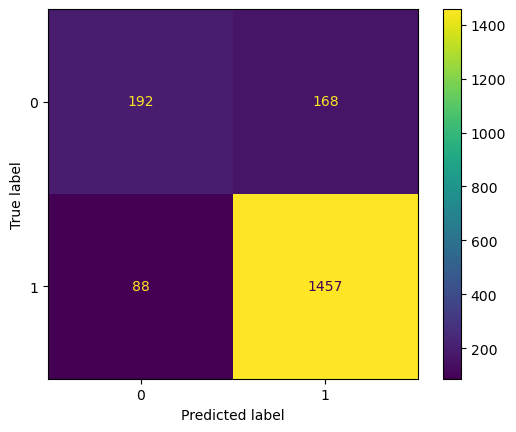

In [19]:
#store single-number metrics in a dictionary
best_metrics = {}

best_metrics["Logistic Regression"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

### Model 2: Logistic Regression with the Synthetic Minority Oversampling Technique (SMOTE)

We'll now address the fact that our classes are imbalanced by augmenting the training data used in each CV split.  To do so, we'll use the `imblearn` library's data augmentation functions.  Of these functions, we find that the Synthetic Minority Oversampling Technique (SMOTE) gives the best performance.

In [20]:
from imblearn.pipeline import Pipeline                                          
from imblearn.over_sampling import SMOTE

In [21]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('log_reg', LogisticRegression(max_iter=10000))])

param_grid = {'log_reg__C': np.logspace(-4, 2, 7)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
      dtype='int64', length=9182),
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'log_reg__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='balanced_accuracy')

In [22]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'log_reg__C': 0.001}
0.8119229251217381


In [23]:
param_grid = {'log_reg__C': [0.0005, 0.00075, 0.001, 0.00125, 0.0015]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
       9562, 9563, 9564, 9565, 9566, 9567, 9568, 9569, 9570, 9571],
      dtype='int64', length=9182),
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'log_reg__C': [0.0005, 0.00075, 0.001, 0.00125,
                                        0.0015]},
             scoring='balanced_accuracy')

In [24]:
best_hyp["Logistic Regression w. SMOTE"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'log_reg__C': 0.0005}
0.8122086809411669


Classification metrics
Avg. bal. accuracy:	 0.8122
Avg. precision:		 0.9593
Avg. recall:		 0.7631
Avg. NPV:		 0.4582
Avg. specificity:	 0.8613


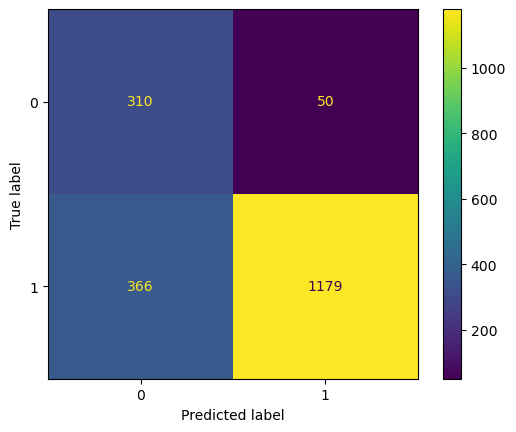

In [25]:
best_metrics["Logistic Regression w. SMOTE"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

Using SMOTE seems to give us a significance improvement in performance for logistic regression. That said, we have noticeably more false negatives after augmenting the data (notice the NPV is much worse).

### Model 3: Linear Discriminant Analysis (LDA)

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [27]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('lda', LinearDiscriminantAnalysis(solver='lsqr'))])

param_grid = {'lda__shrinkage': np.linspace(0, 1, 11)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
      dtype='int64', length=9182),
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('lda',
                                        LinearDiscriminantAnalysis(solver='lsqr'))]),
             param_grid={'lda__shrinkage': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='balanced_accuracy')

In [28]:
best_hyp["LDA"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'lda__shrinkage': 0.2}
0.8090566097260666


Classification metrics
Avg. bal. accuracy:	 0.8091
Avg. precision:		 0.9566
Avg. recall:		 0.7683
Avg. NPV:		 0.4604
Avg. specificity:	 0.8498


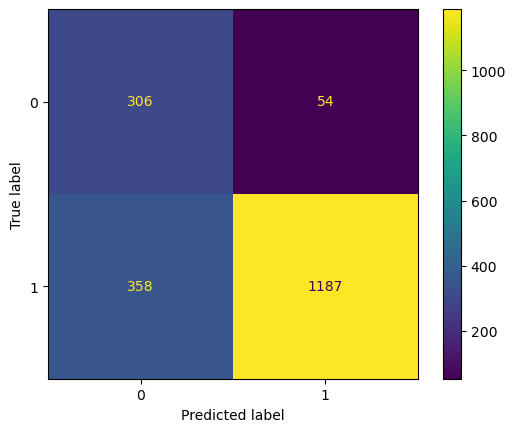

In [29]:
best_metrics["LDA"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

LDA is only slightly behind logistic regression with SMOTE (but has better precision and specificity).

### Model 4: Gaussian Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

In [31]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('gnb', GaussianNB())])

param_grid = {'gnb__var_smoothing': np.logspace(0,-9, num=10)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
      dtype='int64', length=9182),
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('gnb', GaussianNB())]),
             param_grid={'gnb__var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             scoring='balanced_accuracy')

In [32]:
best_hyp["Naive Bayes"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'gnb__var_smoothing': 0.01}
0.7953464043453407


Classification metrics
Avg. bal. accuracy:	 0.7953
Avg. precision:		 0.9658
Avg. recall:		 0.697
Avg. NPV:		 0.4075
Avg. specificity:	 0.8937


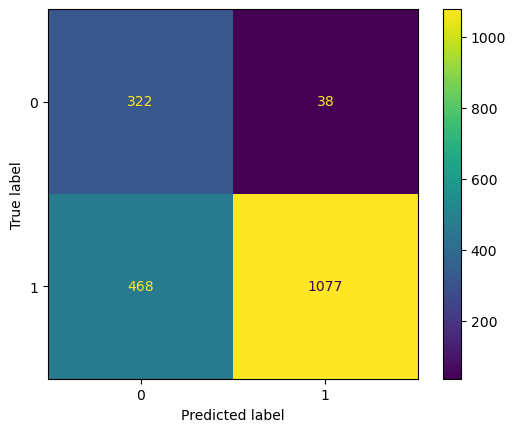

In [33]:
best_metrics["Naive Bayes"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

Naive Bayes performs the worst so far (lowest balanced accuracy score, and NPV is really bad).

### Model 5: Principal Component Analysis (PCA) + K-Nearest Neighborhs (KNN)

Since KNN is suffers from the curse of dimensionality, we will likely need to reduce the number of predictors before using it; we can do so using PCA.

In [34]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

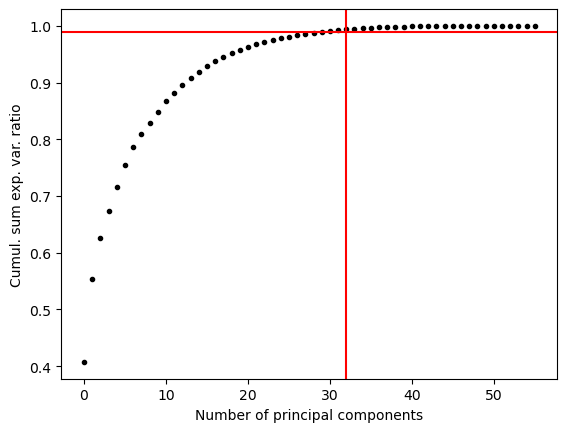

In [35]:
# scale the variables before applying PCA
pca = PCA(n_components=len(predictors))
pca.fit(df_train[predictors])

# grab the explained variance ratio
pca_EVR = pca.explained_variance_ratio_ #get the explained variance ratio

# get the cumulative sum of the explained variance ratio and plot it
pca_EVR_cumul = np.cumsum(pca_EVR)

plt.plot(pca_EVR_cumul, 'k.')
plt.xlabel("Number of principal components")
plt.ylabel("Cumul. sum exp. var. ratio")
plt.axhline(0.99, c='r')
plt.axvline(32, c='r')
plt.show()

From the plot we can see that it takes 32 principal components to explain 99% of the variance in the predictors.

In [69]:
pipe = Pipeline([('pca', PCA()), ('smote', SMOTE(random_state=5)), ('knn', KNeighborsClassifier())])

param_grid = {'pca__n_components': range(25, 35),
              'knn__n_neighbors': range(5, 30)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           verbose=1,
                           n_jobs=8)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('smote', SMOTE(random_state=5)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=8,
             param_grid={'knn__n_neighbors': range(5, 30),
                         'pca__n_components': range(25, 35)},
             scoring='balanced_accuracy', verbose=1)

In [70]:
best_hyp["PCA + KNN"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'knn__n_neighbors': 28, 'pca__n_components': 28}
0.7932421937296553


Classification metrics
Avg. bal. accuracy:	 0.7932
Avg. precision:		 0.9593
Avg. recall:		 0.7172
Avg. NPV:		 0.4169
Avg. specificity:	 0.8692


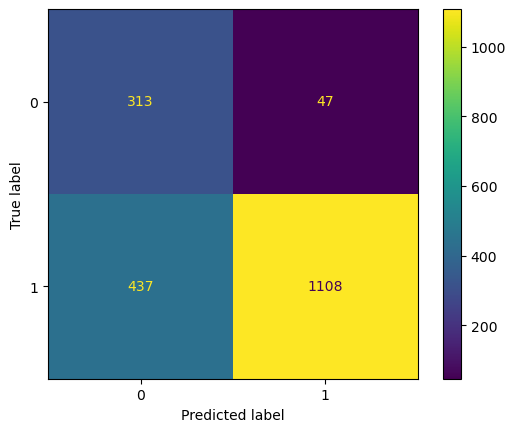

In [71]:
best_metrics["PCA + KNN"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

PCA + KNN performs similarly to LDA.

### Model 6: Principal Component Analysis (PCA) + Quadratic Discriminant Analysis (QDA)

QDA doesn't converge well if our predictors are colinear, as is the case here.  We'll use PCA to generate an orthogonal basis of predictors before using QDA.

In [39]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [40]:
pipe = Pipeline([('pca', PCA()), ('smote', SMOTE(random_state=5)), ('qda', QuadraticDiscriminantAnalysis())])

param_grid = {'pca__n_components': [30],
              'qda__reg_param': np.linspace(0,1,11)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('smote', SMOTE(random_state=5)),
                                       ('qda',
                                        QuadraticDiscriminantAnalysis())]),
             param_grid={'pca__n_components': [30],
                         'qda__reg_param': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='balanced_accuracy')

In [41]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'pca__n_components': 30, 'qda__reg_param': 0.4}
0.8113859983467334


In [42]:
pipe = Pipeline([('pca', PCA()), ('smote', SMOTE(random_state=5)), ('qda', QuadraticDiscriminantAnalysis())])

param_grid = {'pca__n_components': range(25, 35),
              'qda__reg_param': [0.3]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

/home/alex/anaconda3/envs/nba_pred/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
      dtype='int64', length=9182),
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('smote', SMOTE(random_state=5)),
                                       ('qda',
                                        QuadraticDiscriminantAnalysis())]),
             param_grid={'pca__n_components': range(25, 35),
                         'qda__reg_param': [0.3]},
             scoring='balanced_accuracy')

In [43]:
best_hyp["PCA + QDA"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'pca__n_components': 34, 'qda__reg_param': 0.3}
0.8107425543698692


Classification metrics
Avg. bal. accuracy:	 0.8107
Avg. precision:		 0.956
Avg. recall:		 0.7747
Avg. NPV:		 0.4671
Avg. specificity:	 0.8468


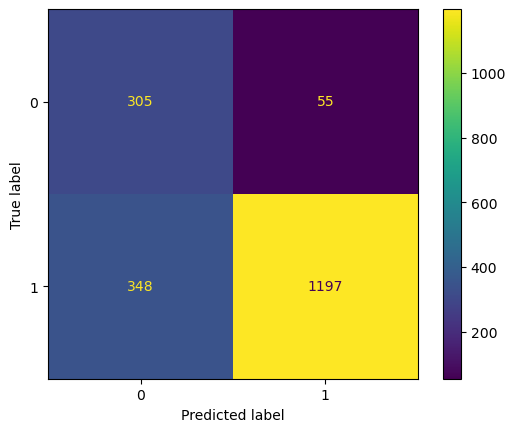

In [44]:
best_metrics["PCA + QDA"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

PCA + QDA performs _very_ similarly to logistic regression with SMOTE, just a tad bit worse.

## Model 7: Decision Tree Classifier

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('tree', DecisionTreeClassifier(random_state=25))])

param_grid = {'tree__criterion': ['gini', 'log_loss'],
              'tree__max_depth': [5, 10, 15, None]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           n_jobs=8)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=25))]),
             n_jobs=8,
             param_grid={'tree__criterion': ['gini', 'log_loss'],
                         'tree__max_depth': [5, 10, 15, None]},
             scoring='balanced_accuracy')

In [47]:
best_hyp["Decision Tree"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'tree__criterion': 'gini', 'tree__max_depth': 5}
0.7916809964307797


Classification metrics
Avg. bal. accuracy:	 0.7917
Avg. precision:		 0.9414
Avg. recall:		 0.7962
Avg. NPV:		 0.4759
Avg. specificity:	 0.7871


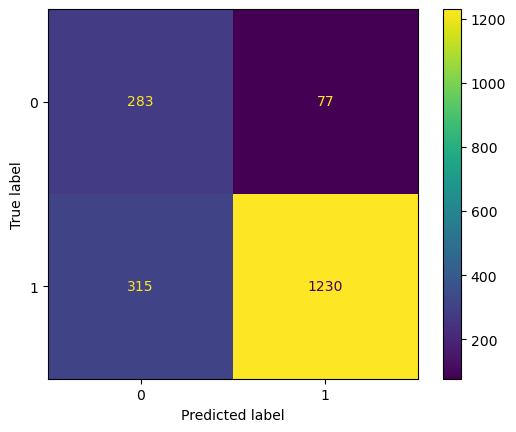

In [48]:
best_metrics["Decision Tree"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

Decision tree classifier performs slightly better than LDA (with significantly better NPV).

### Model 8: Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('rfc', RandomForestClassifier(random_state=25))])

param_grid = {'rfc__n_estimators': [50, 100, 250, 500],
              'rfc__max_depth': [5, 10, 20, None]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           verbose=1,
                           n_jobs=8)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=25))]),
             n_jobs=8,
             param_grid={'rfc__max_depth': [5, 10, 20, None],
                         'rfc__n_estimators': [50, 100, 250, 500]},
             scoring='balanced_accuracy', verbose=1)

In [51]:
best_hyp["Random Forest"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'rfc__max_depth': 5, 'rfc__n_estimators': 100}
0.812978611471005


Classification metrics
Avg. bal. accuracy:	 0.813
Avg. precision:		 0.9498
Avg. recall:		 0.8091
Avg. NPV:		 0.4989
Avg. specificity:	 0.8169


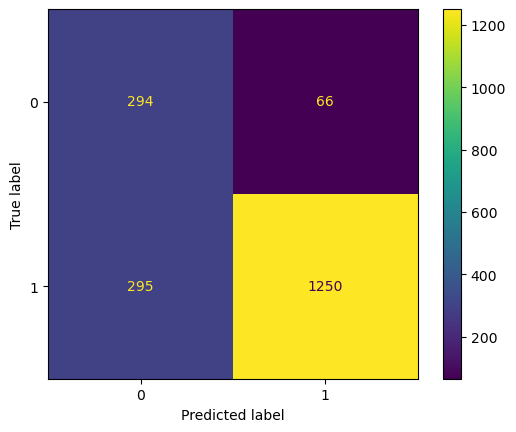

In [52]:
best_metrics["Random Forest"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

Random forest classifier has average balanced accuracy comparable to logistic regression with SMOTE (just 0.8% less), but with improved NPV (by about 2.5%). Trades some specificity for an increase in sensitivity (i.e., recall).

### Model 9: AdaBoost Classifier

In [53]:
from sklearn.ensemble import AdaBoostClassifier

In [54]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('ada', AdaBoostClassifier(algorithm='SAMME', random_state=25))])

param_grid = {'ada__n_estimators': [50, 100, 250, 500],
              'ada__learning_rate': [0.01, 0.1, 1]}
            #   'ada__base_estimator__max_depth': [1, 2, 3]}


grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           verbose=1,
                           n_jobs=8)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
                  Index([   4,   11,   15,   30,   43,   51,   86,  105,  119,  130,
       ...
       9409, 9416, 9455, 9478, 9502, 9532, 9541, 9544, 9554, 9556],
      dtype='int64', length=390))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('ada',
                                        AdaBoostClassifier(algorithm='SAMME',
                                                           random_state=25))]),
             n_jobs=8,
             param_grid={'ada__learning_rate': [0.01, 0.1, 1],
                         'ada__n_estimators': [50, 100, 250, 500]},
             scoring='balanced_accuracy', verbose=1)

In [55]:
best_hyp["AdaBoost"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'ada__learning_rate': 0.1, 'ada__n_estimators': 100}
0.8113801255862402


Classification metrics
Avg. bal. accuracy:	 0.8114
Avg. precision:		 0.9555
Avg. recall:		 0.7773
Avg. NPV:		 0.4703
Avg. specificity:	 0.8454


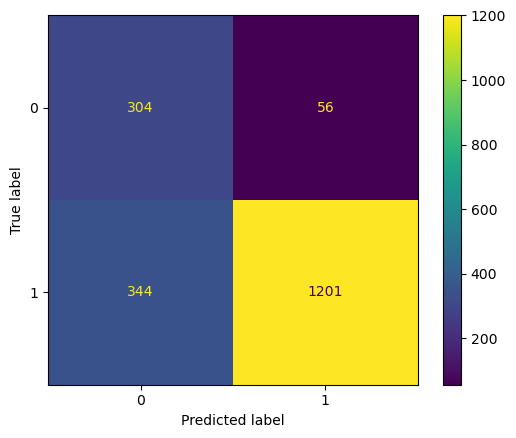

In [56]:
best_metrics["AdaBoost"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

AdaBoost performs similar to decision tree classifier (better balanced accuracy, slightly worse NPV).

### XGBoost Classifier

In [26]:
from xgboost import XGBClassifier

In [58]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('xgb', XGBClassifier(random_state=25))])

param_grid = {'xgb__n_estimators': [50, 100, 250, 500],
              'xgb__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           verbose=1,
                           n_jobs=8)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=25, ...))]),
             n_jobs=8,
             param_grid={'xgb__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
                         'xgb__n_estimators': [50, 100, 250, 500]},
             scoring='balanced_accuracy', verbose=1)

In [59]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'xgb__learning_rate': 0.005, 'xgb__n_estimators': 250}
0.8120859127110105


In [60]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('xgb', XGBClassifier(random_state=25))])

param_grid = {'xgb__n_estimators': [300, 350, 400, 450],
              'xgb__learning_rate': [0.005]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           verbose=1,
                           n_jobs=8)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=[(Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9558, 9559, 9560, 9562, 9564, 9565, 9567, 9568, 9570, 9571],
      dtype='int64', length=7667),
                  Index([  34,   38,  136,  147,  161,  245,  303,  326,  355,  362,
       ...
       9351, 9360, 9381, 9433, 9457, 9472, 9501, 9503, 9527, 9566],
      dtype='int64', length=370)),
                 (Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   12,
       ...
       9559, 9560, 9562, 9564, 9565, 9566, 9567, 9568, 9570, 9571],
      dtype='int64',...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=25, ...))]),
             n_jobs=8,
             param_grid={'xgb__learning_rate': [0.005],
                         'xgb__n_estimators': [300, 350, 400, 450]},
             scoring='balanced_accuracy', verbose=1)

In [61]:
best_hyp["XGBoost"] = grid_search.best_params_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'xgb__learning_rate': 0.005, 'xgb__n_estimators': 350}
0.8132620538711963


Classification metrics
Avg. bal. accuracy:	 0.8133
Avg. precision:		 0.9455
Avg. recall:		 0.8318
Avg. NPV:		 0.5244
Avg. specificity:	 0.7947


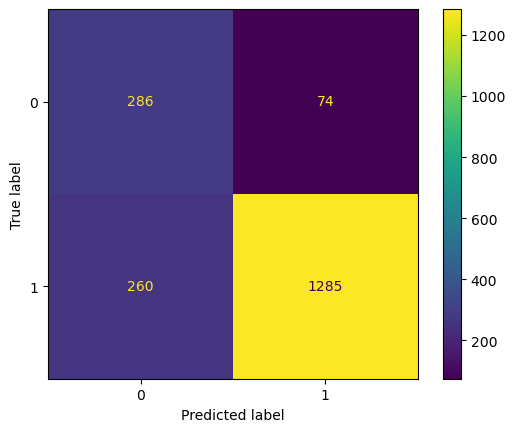

In [62]:
best_metrics["XGBoost"] = print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

XGBoost has the best balanced accuracy and the best NPV (except for logistic regression _without_ SMOTE, which has the worst balanced accuracy). Also, XGBoost has the most balanced sensitivity (i.e., recall) and specificity out of any of our models (random forest is close, but not quite as balanced).

## Summary and final model selection

In [72]:
print_summary(best_metrics, best_hyp)

,Model,Balanced accuracy,Precision,Recall,NPV,Specificity,Hyperparameters
0,XGBoost,0.813262,0.945509,0.831833,0.524431,0.794691,"[learning_rate=0.005, n_estimators=350]"
1,Random Forest,0.812979,0.949834,0.809053,0.498894,0.816905,"[max_depth=5, n_estimators=100]"
2,Logistic Regression w. SMOTE,0.812209,0.959324,0.763128,0.458151,0.861289,[C=0.0005]
3,AdaBoost,0.811380,0.955494,0.777333,0.470282,0.845427,"[learning_rate=0.1, n_estimators=100]"
4,PCA + QDA,0.810743,0.955982,0.774734,0.467141,0.846751,"[n_components=34, reg_param=0.3]"
5,LDA,0.809057,0.956569,0.768299,0.460419,0.849815,[shrinkage=0.2]
6,Naive Bayes,0.795346,0.965781,0.696952,0.407541,0.893741,[var_smoothing=0.01]
7,PCA + KNN,0.793242,0.959347,0.717234,0.416948,0.869250,"[n_neighbors=28, n_components=28]"
8,Decision Tree,0.791681,0.941354,0.796224,0.475857,0.787138,"[criterion=gini, max_depth=5]"
9,Logistic Regression,0.737013,0.896672,0.942979,0.685046,0.531047,[C=10.0]


Based on our findings, we will select an ***XGBoost Classifier (with SMOTE)*** with hyperparameters `n_estimators=350` and `learning_rate=0.005` as our final model. It has the highest balanced accuracy, and the best NPV (beside logistic regression without SMOTE, which is to be expected), and has the most balanced sensitivity (i.e., recall) and specificity.

## Model calibration

We will now evaluate the calibration of the predicted probabilities for our best-performing model (XGBoost with SMOTE, `n_estimators=350, learning_rate=0.005`).

We begin by instantiating and re-training the chosen model.

In [27]:
final_model = Pipeline([('smote', SMOTE(random_state=5)),
                        ('xgb', XGBClassifier(random_state=25, n_estimators=350, learning_rate=0.005))])

final_model.fit(df_train[predictors], df_train.IN_LEAGUE_NEXT)

Pipeline(steps=[('smote', SMOTE(random_state=5)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.005, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=350,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=25, ...))])

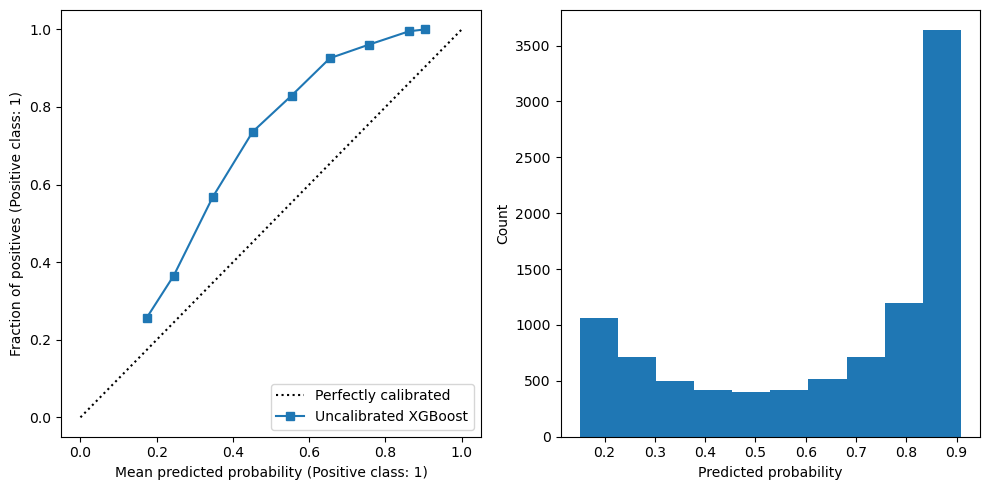

Brier score: 0.11756273837035693


In [28]:
display_calibration(final_model, df_train, predictors, "Uncalibrated XGBoost")

We can see that the model's predicted probabilities always lie about the dotted line, meaning that we always have a greater fraction of positives (players that are retained) than the model's predicted probability would imply.

Below we use the unseen calibration set `df_cal` to train a calibrator which will

In [29]:
from sklearn.calibration import CalibratedClassifierCV

In [34]:
calibrated_final_model = CalibratedClassifierCV(final_model, cv="prefit")
calibrated_final_model.fit(df_cal[predictors], df_cal.IN_LEAGUE_NEXT)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('smote',
                                                  SMOTE(random_state=5)),
                                                 ('xgb',
                                                  XGBClassifier(base_score=None,
                                                                booster=None,
                                                                callbacks=None,
                                                                colsample_bylevel=None,
                                                                colsample_bynode=None,
                                                                colsample_bytree=None,
                                                                device=None,
                                                                early_stopping_rounds=None,
                                                                enable_categorical=False,
                                                                eval_metric=None,
                                                                feature_types=None,
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.005,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=None,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=350,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=25, ...))]))

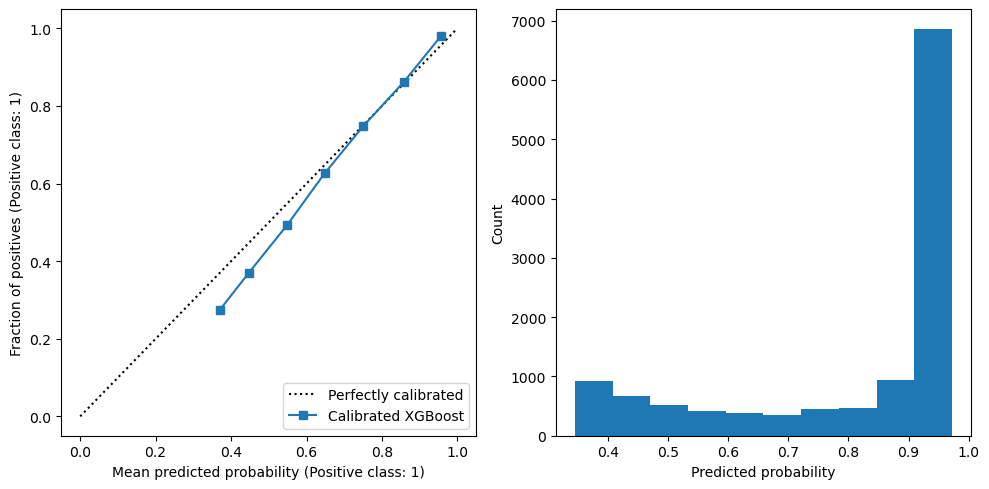

Brier score: 0.0929153199872463


In [35]:
display_calibration(calibrated_final_model, df, predictors, "Calibrated XGBoost")